In [ ]:
Student_number = '402105727'
First_name = 'Matin'
Last_name = 'Bagheri'

# Section 1: Image Compression with SVD

## Problem Statement:
Singular Value Decomposition is a widely used dimentionality reduction technique. We can use SVD for Image Size Reduction that is compressing the image.

## Introduction:

The Singular Value Decomposition (SVD) is a foundational technique in linear algebra that breaks down any matrix into three interpretable components: **left singular vectors**, **singular values**, and **right singular vectors**. These components reveal the hidden structure of the data, akin to identifying the "building blocks" that explain its variability. The singular values quantify the importance of each latent component, while the singular vectors define their orientation. By sorting these components by descending singular values, we immediately see which features capture the most variance—a principle leveraged in dimensionality reduction (e.g., PCA) and image compression. With SVD, we can reconstruct the original data using only the top components, discarding noise or redundant features, making it a powerful tool for simplifying complex datasets while preserving critical information.



## Importing the libraries

In [ ]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os

## Importing the Image to Reduce and setting the plot size
imread converts the original image to numpy array

In [2]:
plt.rcParams['figure.figsize'] = [20,8]
image = imread('Pishi.webp')

## Converting the image to grayscale
By converting an RGB image to grayscale, we can remove the color information from the image and simplify it to a single channel of brightness values. This can make the image easier to process and analyze, particularly if we are only interested in the overall shape or texture of the image.

In [5]:
# convert RGB to Grayscale
X = np.mean(image, -1)
# check the original image shape
print(X.shape)

(1080, 1080)


## Displaying the original image:

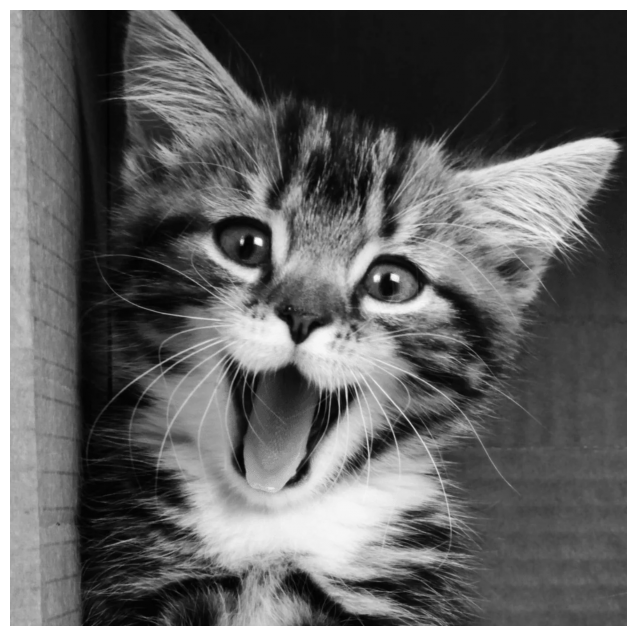

In [6]:
img = plt.imshow(X)
img.set_cmap('gray')
plt.axis('off')
plt.show()

## Computing the SVD of the image:

### **eigh function:**

This implementation demonstrates how to compute eigenvalues/vectors of symmetric matrices using the QR algorithm with shifts. We use this method because:

- Efficiency: The QR algorithm is numerically stable and converges quickly for symmetric matrices.

- Shift Strategy: Using a Rayleigh quotient shift (bottom-right element of the matrix) accelerates convergence by targeting specific eigenvalues.

- Foundation for SVD: Eigenvalue decomposition of symmetric matrices is a critical step in Singular Value Decomposition (SVD), which is widely used in image processing, data compression, and principal component analysis (PCA).

In [23]:
def eigh(A, max_iter=100, tol=1e-10):
    """
    Compute eigenvalues and eigenvectors of a symmetric matrix using the QR algorithm with shifts.

    Args:
        A: Symmetric input matrix (n x n).
        max_iter: Maximum number of iterations.
        tol: Tolerance for convergence (checks if off-diagonal elements are near zero).

    Returns:
        eigenvalues: Array of eigenvalues sorted in descending order.
        V: Matrix whose columns are the corresponding eigenvectors.
    """
    n = A.shape[0]
    A = A.astype(float)
    V = np.eye(n)  # Eigenvectors accumulated here

    for _ in range(max_iter):
        # Compute shift using the Rayleigh quotient (bottom-right element)
        shift = A[n-1, n-1]

        # Apply QR decomposition with shift
        Q, R = np.linalg.qr(A - shift * np.eye(n))

        # Update A and eigenvectors
        A = R @ Q + shift * np.eye(n)
        V = V @ Q

        # Check for convergence (off-diagonal elements near zero)
        if np.all(np.abs(np.triu(A, k=1)) < tol):
            break

    # Extract eigenvalues from the diagonal of A
    eigenvalues = np.diag(A)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    V = V[:, sorted_indices]

    return eigenvalues, V

### **svd function:**

This function computes the Singular Value Decomposition (SVD) of a matrix X, which factorizes it into three matrices:

$X = UΣV^T$

where:

$U$: Orthogonal matrix of left singular vectors (columns).

$Σ$: Diagonal matrix of singular values (non-negative, sorted in descending order).

$V^T$: Orthogonal matrix of right singular vectors (rows).


In [24]:
def svd(X):
    """
    Compute the Singular Value Decomposition (SVD) of a real matrix X.

    Parameters
    ----------
    X : numpy.ndarray, shape (m, n)
        Input matrix to decompose. Must be a 2D array of real numbers.

    Returns
    -------
    U : numpy.ndarray, shape (m, m)
        Left singular vectors (orthonormal columns).
    S : numpy.ndarray, shape (k,)
        Singular values sorted in descending order, where k = min(m, n).
    VT : numpy.ndarray, shape (n, n)
        Transpose of the right singular vectors (orthonormal rows).

    Notes
    -----
    - For numerical stability, near-zero singular values are thresholded to avoid division by zero.
    - Uses eigenvalue decomposition of X^T X (if m >= n) or XX^T (if m < n) for efficiency.
    """
    m, n = X.shape

    if m >= n:
        # Compute X^T X and its eigenvalue decomposition
        C = X.T @ X
        eigenvalues, V = np.linalg.eigh(C)

        # Sort eigenvalues and eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        V = V[:, sorted_indices]

        # Singular values (ensure non-negative due to numerical precision)
        S = np.sqrt(np.maximum(eigenvalues, 0))

        # Compute U using X and V
        # Handle the case where singular values are zero to avoid division by zero
        non_zero_singular_values = S > 1e-10
        U = np.zeros((m, n))
        U[:, non_zero_singular_values] = X @ V[:, non_zero_singular_values] / S[non_zero_singular_values]
        VT = V.T

    else:
        # Compute X X^T and its eigenvalue decomposition
        C = X @ X.T
        eigenvalues, U = np.linalg.eigh(C)

        # Sort eigenvalues and eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        U = U[:, sorted_indices]

        # Singular values (ensure non-negative due to numerical precision)
        S = np.sqrt(np.maximum(eigenvalues, 0))

        # Compute V using X and U
        # Handle the case where singular values are zero to avoid division by zero
        non_zero_singular_values = S > 1e-10
        VT = np.zeros((n, m))
        VT[non_zero_singular_values, :] = (X.T @ U[:, non_zero_singular_values]).T / S[non_zero_singular_values]
        VT = VT.T

    return U, S, VT

In [25]:
U, S, VT = svd(X)

## Reconstruct the image for different values of r:

The number of retained singular values, *r*, determines the balance between reconstruction quality and compression efficiency in SVD-based image compression. When *r* is large (e.g., close to the full rank of the image matrix), the reconstructed image closely matches the original, as more singular values preserve fine details. However, this comes at a cost: the compressed representation requires storing *r* singular values along with *r* left and right singular vectors, resulting in a larger file size. The compression ratio, defined as *(r × (1 + rows + columns)) / (rows × columns)*, increases with *r*, meaning less storage savings. Conversely, small *r* (e.g., a few dozen components) discards minor variations and noise, producing a blurrier image but drastically reducing storage.

In [26]:
def plot_svd_approximations(original_img, U, S, VT, ranks=(5, 20, 100)):
    """
    Visualize original image + low-rank approximations with compression ratios.

    Parameters
    ----------
    original_img : numpy.ndarray
        Original image matrix
    U : numpy.ndarray
        Left singular vectors
    S : numpy.ndarray
        Singular values
    VT : numpy.ndarray
        Transposed right singular vectors
    ranks : tuple of int, optional
        Ranks to use for approximation (default: (5, 20, 100))
    """
    plt.figure(figsize=(15, 4))
    num_plots = len(ranks) + 1
    row_dim, col_dim = original_img.shape

    # Plot original image
    plt.subplot(1, num_plots, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title(f'Original\n{row_dim}x{col_dim}')
    plt.axis('off')

    # Convert singular values to diagonal matrix
    S_diag = np.diag(S)

    for idx, r in enumerate(ranks, start=2):
        plt.subplot(1, num_plots, idx)
        # Construct rank-r approximation
        X_approx = U[:, :r] @ S_diag[:r, :r] @ VT[:r, :]
        plt.imshow(X_approx, cmap='gray')

        # Calculate compression ratio
        compression_ratio = (r * (1 + row_dim + col_dim)) / (row_dim * col_dim)

        plt.title(f'Rank-{r}\n({compression_ratio*100:.1f}% size)')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

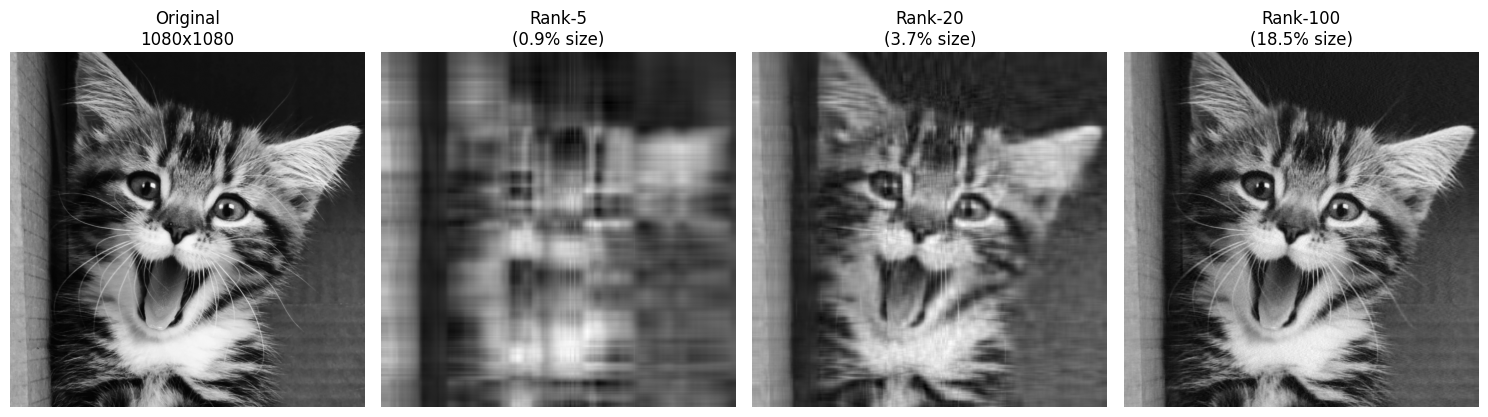

In [27]:
plot_svd_approximations(X, U, S, VT, ranks=(5, 20, 100))

## Singular Vlaues of latent Component:
**Singular Values vs Latent Component:**

- Use `plt.semilogy` to plot the singular values (logarithmic y-axis).

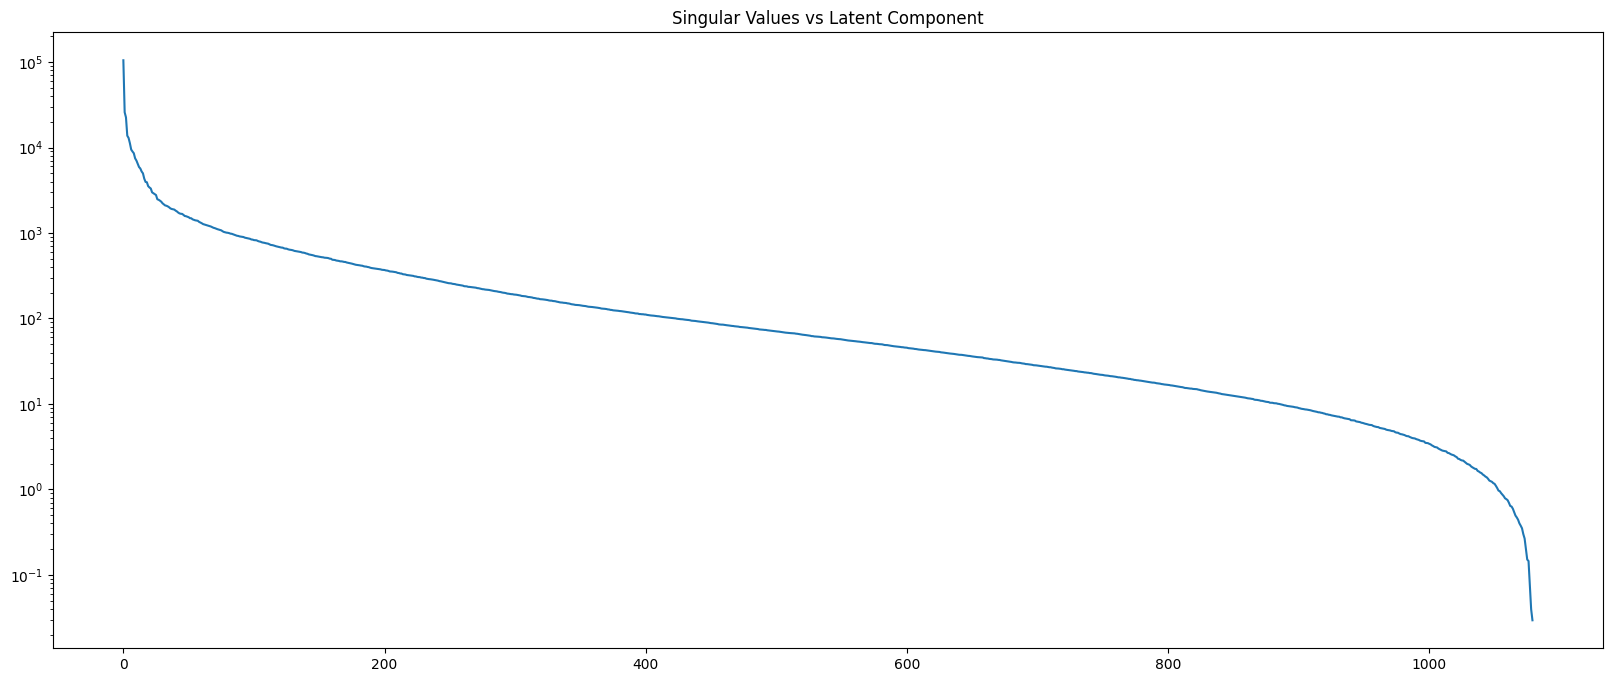

In [28]:
plt.figure(figsize=[20, 8])
plt.semilogy(S)
plt.title('Singular Values vs Latent Component')
plt.show()

## Cumulative sum of the variability captured
**Latent Component: Cumulative Sum of the variability captured:**

- Compute the cumulative sum of singular values normalized by their total sum.
- Plot this ratio on a linear scale.

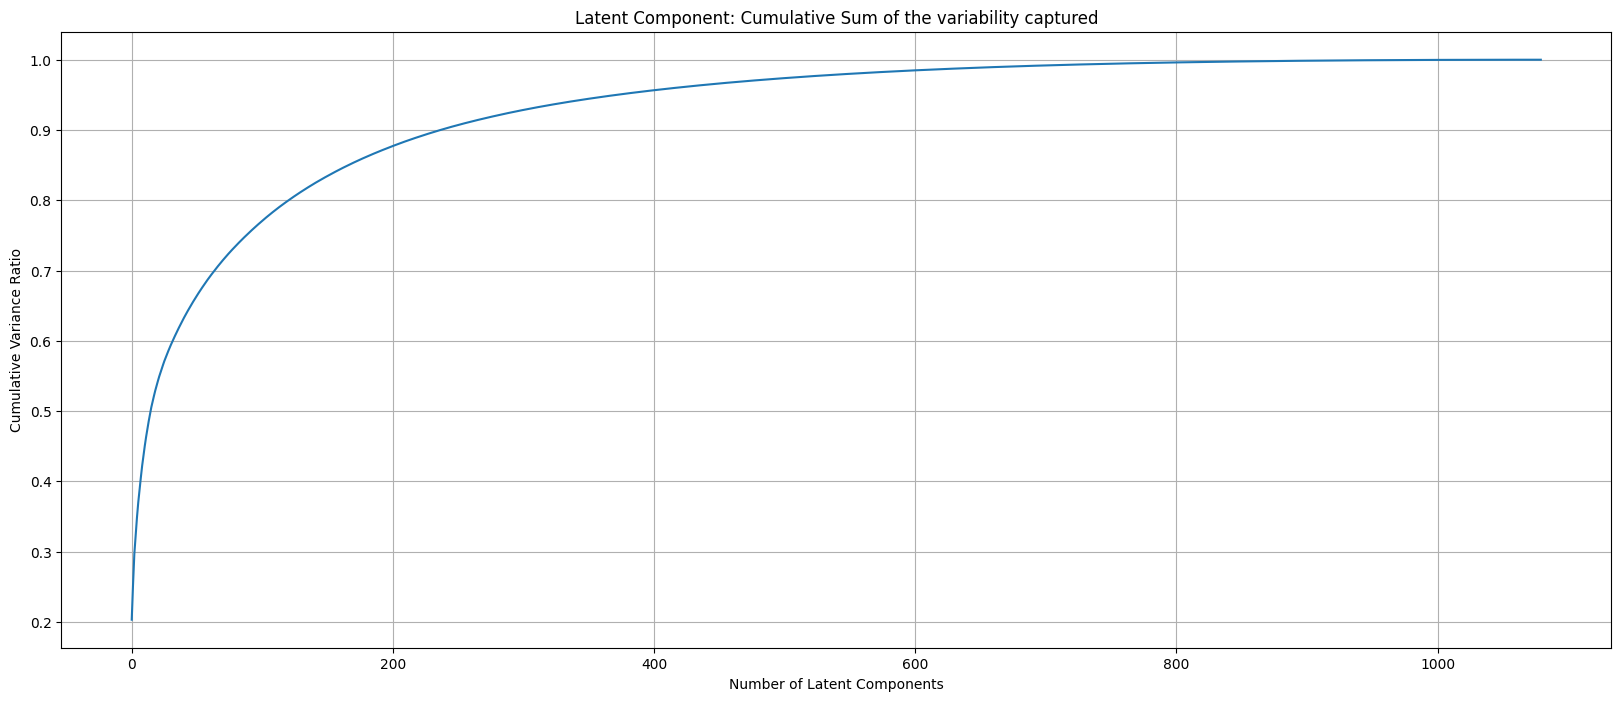

In [29]:
# Compute the cumulative sum of singular values
cumulative_variance = np.cumsum(S)

# Normalize the cumulative sum by the total sum of singular values
normalized_cumulative_variance = cumulative_variance / np.sum(S)

# Plot the normalized cumulative sum
plt.figure(figsize=[20, 8])
plt.plot(normalized_cumulative_variance)
plt.title('Latent Component: Cumulative Sum of the variability captured')
plt.xlabel('Number of Latent Components')
plt.ylabel('Cumulative Variance Ratio')
plt.grid(True)
plt.show()

## Conclusion:

Based on your plots, answer the following questions:

- How rapidly do the singular values decay? What does this imply about the dataset’s latent structure?

    *The singular values decay rapidly, implying the image has a low-rank latent structure and most information is in the largest singular values.*

- How many latent components are required to capture 90% of the variability in the data?

    *Approximately 150 latent components are needed to capture 90% of the variability.*

- Could you truncate the latent components for dimensionality reduction without significant loss of information?

    *Yes, truncation is possible without significant loss of essential information due to the rapid decay of singular values.*

# Section 2: Comparing Compression Effects on Sharp vs. Smooth-Edged Images

## Introduction
Investigate how SVD compression affects images with sharp edges (e.g., text, geometric shapes) versus smooth-edged images (e.g., portraits, landscapes).


## Importing the libraries

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr

## Load and Display Images
Load two representative images (one sharp-edged, one smooth-edged).

In [32]:
# Load images
sharp_img = plt.imread('Pishi.webp')
smooth_img = plt.imread('Nature.jpg')

# Convert to grayscale if needed
sharp_img = np.mean(sharp_img, -1)
smooth_img = np.mean(smooth_img, -1)

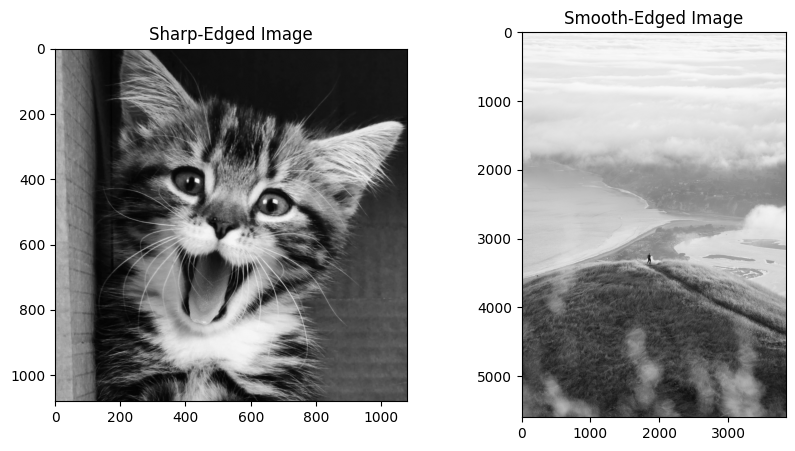

In [33]:
# Display
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sharp_img, cmap='gray')
ax[0].set_title('Sharp-Edged Image')
ax[1].imshow(smooth_img, cmap='gray')
ax[1].set_title('Smooth-Edged Image')
plt.show()

## Reconstruct Images at Different k Values
- Test compression quality and visualize results for both images using our custom `plot_svd_approximations` function from Section 1.
- Test compression with multiple ranks (e.g., k=5, 20, 50, 100).

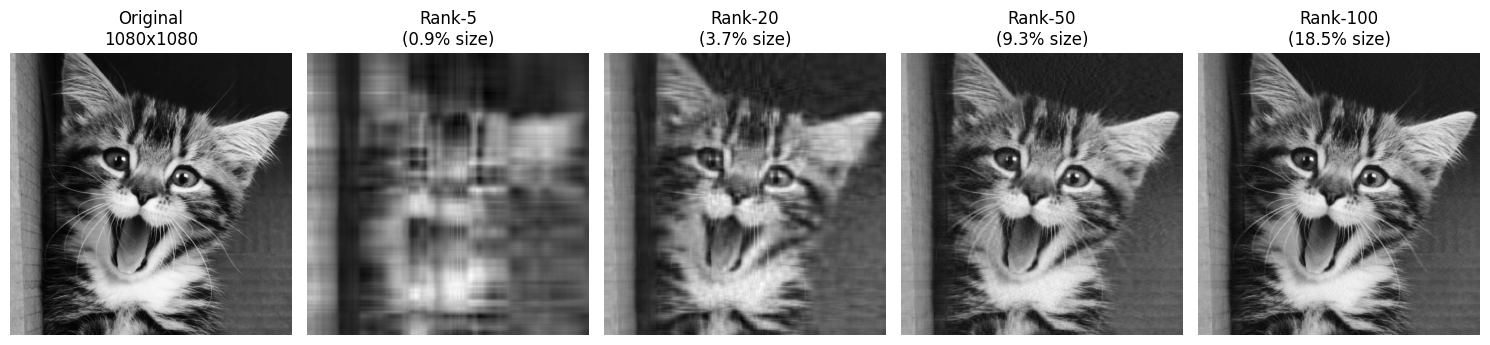

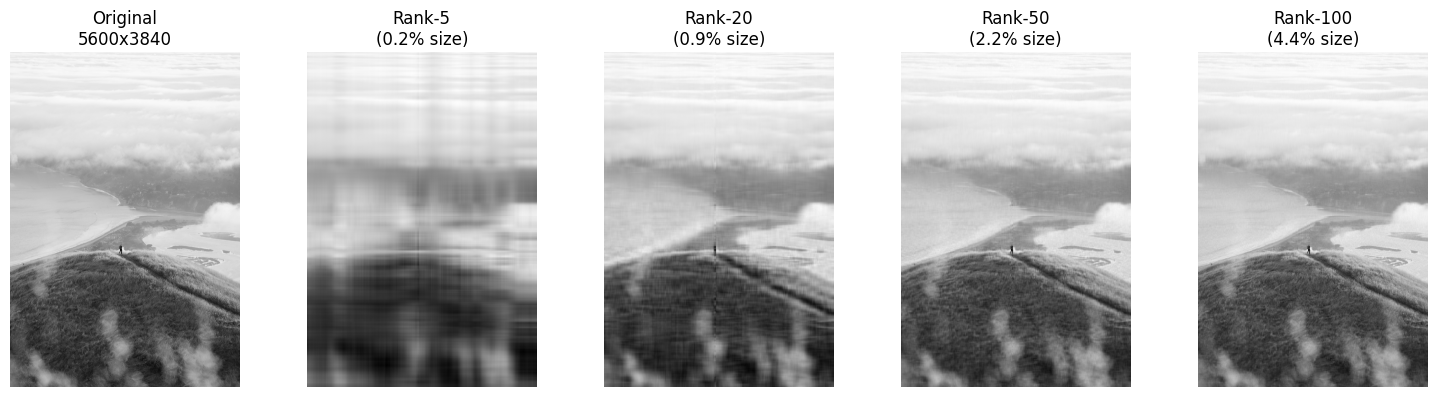

In [34]:
def full_analysis(img, title):
    """
    Complete analysis pipeline for an image:
    1. Compute SVD decomposition
    2. Generate visualization with original + compressed versions
    3. Display compression metrics

    Parameters:
    img (numpy.ndarray): Input image matrix
    title (str): Title for the visualization
    """
    # Compute SVD decomposition
    U, S, VT = svd(img)

    # Generate visualization with original + compressed versions
    ranks_to_plot = (5, 20, 50, 100) # Using more ranks for comparison
    plot_svd_approximations(img, U, S, VT, ranks=ranks_to_plot)

    # Store reconstructed images for metric calculation
    reconstructed_images = {}
    S_diag = np.diag(S)
    for r in ranks_to_plot:
        reconstructed_images[r] = U[:, :r] @ S_diag[:r, :r] @ VT[:r, :]

    return reconstructed_images


# Run for both images
sharp_recons = full_analysis(sharp_img, 'Sharp-Edged Image Compression')
smooth_recons = full_analysis(smooth_img, 'Smooth-Edged Image Compression')

## Numerical Analysis (MSE/PSNR)
**Mean Squared Error (MSE):**

MSE quantifies the average squared difference between pixel values in the original and reconstructed images. A lower MSE indicates better preservation of image fidelity, as it directly measures how "close" the compressed image is to the original in terms of pixel-level accuracy. Mathematically, it penalizes larger errors more heavily due to the squaring operation, making it sensitive to outliers and structural distortions like blurred edges or artifacts. While MSE provides an objective measure of reconstruction quality, it does not always align perfectly with human visual perception—small MSE differences may be imperceptible to the eye, while larger deviations often correspond to noticeable quality degradation.

**Peak Signal-to-Noise Ratio (PSNR):**

PSNR measures the ratio between the maximum possible pixel intensity (e.g., 255 for 8-bit images) and the reconstruction error, expressed in decibels (dB). Derived from MSE, it provides a logarithmic scale that better matches human sensitivity to intensity variations. Higher PSNR values indicate superior reconstruction quality, with values above 30 dB generally considered acceptable for lossy compression. PSNR is particularly useful for comparing compression performance across different images or algorithms, as it normalizes the error relative to the signal range. However, like MSE, PSNR has limitations—it may fail to capture nuanced perceptual degradations in textured or edge-rich regions, where human vision is most sensitive.

In [35]:
def calculate_metrics(orig, recon):
    # Determine data range automatically
    data_range = 255 if orig.max() > 1 else 1
    return {
        'MSE': mse(orig, recon),
        'PSNR': psnr(orig, recon, data_range=data_range)
    }

# Calculate metrics for both images
sharp_metrics = {k: calculate_metrics(sharp_img, recon) for k, recon in sharp_recons.items()}
smooth_metrics = {k: calculate_metrics(smooth_img, recon) for k, recon in smooth_recons.items()}

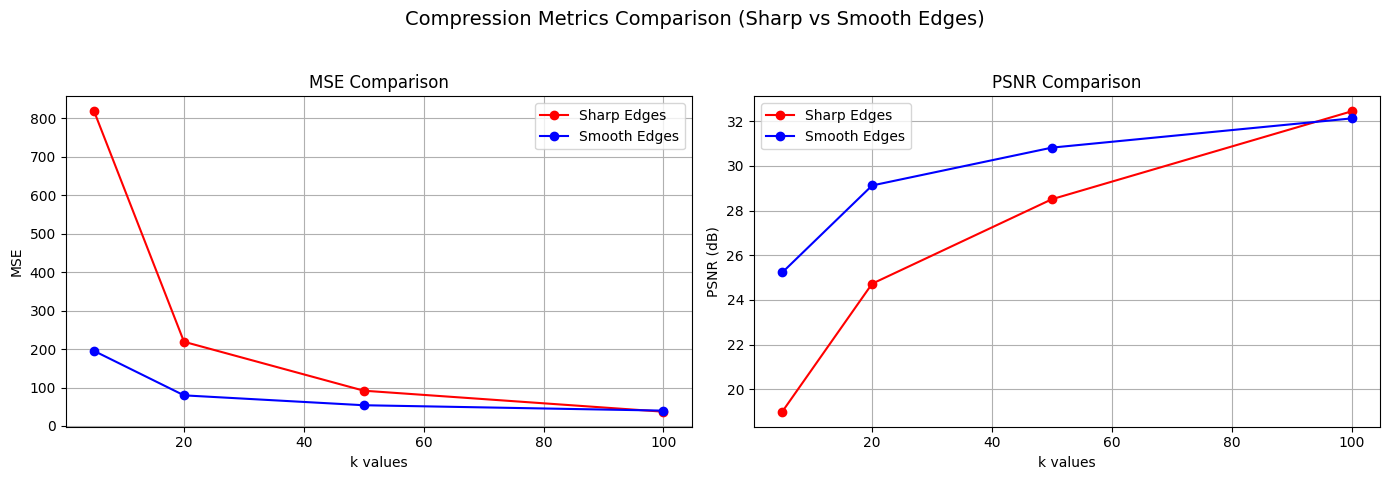

In [36]:
def plot_combined_metrics(sharp_metrics, smooth_metrics, title_suffix=''):
    """
    Visual comparison of compression metrics between two image types

    Parameters:
    sharp_metrics (dict): Dictionary of metrics for sharp-edged image
                        format: {k: {'MSE': value, 'PSNR': value}}
    smooth_metrics (dict): Dictionary of metrics for smooth-edged image
    title_suffix (str): Additional text for plot title
    """
    # Create a figure with two subplots (one for MSE, one for PSNR)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'Compression Metrics Comparison {title_suffix}', fontsize=14)

    # Plot MSE
    ranks_sharp = sorted(sharp_metrics.keys())
    mse_sharp = [sharp_metrics[r]['MSE'] for r in ranks_sharp]
    axes[0].plot(ranks_sharp, mse_sharp, marker='o', color='red', label='Sharp Edges')

    ranks_smooth = sorted(smooth_metrics.keys())
    mse_smooth = [smooth_metrics[r]['MSE'] for r in ranks_smooth]
    axes[0].plot(ranks_smooth, mse_smooth, marker='o', color='blue', label='Smooth Edges')

    axes[0].set_title('MSE Comparison')
    axes[0].set_xlabel('k values')
    axes[0].set_ylabel('MSE')
    axes[0].grid(True)
    axes[0].legend()

    # Plot PSNR
    psnr_sharp = [sharp_metrics[r]['PSNR'] for r in ranks_sharp]
    axes[1].plot(ranks_sharp, psnr_sharp, marker='o', color='red', label='Sharp Edges')

    psnr_smooth = [smooth_metrics[r]['PSNR'] for r in ranks_smooth]
    axes[1].plot(ranks_smooth, psnr_smooth, marker='o', color='blue', label='Smooth Edges')


    axes[1].set_title('PSNR Comparison')
    axes[1].set_xlabel('k values')
    axes[1].set_ylabel('PSNR (dB)')
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

plot_combined_metrics(sharp_metrics, smooth_metrics, '(Sharp vs Smooth Edges)')

## Conclusion

1. **Observe the Trends**:  
   - How do the MSE and PSNR curves differ between sharp-edged and smooth-edged images as *k* increases?    

      *MSE: For both sharp-edged and smooth-edged images, the MSE decreases as the number of latent components (k) increases.
      PSNR: For both image types, the PSNR increases as k increases.
      In both cases, Sharp Edge value changes more rapidly.*

2. **Explain the Differences**:  
   - Why do sharp-edged images consistently show higher MSE and lower PSNR than smooth-edged images at the same *k*?

      *Sharp edges represent high-frequency information in an image, involving rapid changes in pixel intensity. Smooth-edged images, like landscapes, have more low-frequency information with gradual transitions. SVD compression, by retaining only the largest singular values, effectively filters out some of the high-frequency details. Sharp edges require more singular values to be accurately represented compared to smoother areas. Therefore, at the same level of compression (same k), SVD struggles more to reconstruct the fine details and abrupt changes in sharp-edged images, leading to larger errors (higher MSE) and a lower signal-to-noise ratio (lower PSNR).*

   - What does this imply about the relationship between edge complexity and the number of singular values needed for faithful reconstruction?  

      *This implies that images with higher edge complexity or more detailed textures require a larger number of singular values (k) for faithful reconstruction compared to images with smoother transitions and less detail. More complex images have more significant components across the singular values spectrum that contribute meaningfully to the image structure, whereas simpler, smoother images have most of their information captured by a smaller subset of the largest singular values.*

3. **Practical Implications**:  
   - Would you recommend the same compression ratio (*k*) for both image types? Why or why not?  

      *No, I would generally not recommend the same compression ratio (k) for both image types if the goal is to achieve similar perceptual quality. To achieve comparable quality, a sharp-edged image would likely require a higher k (and thus a lower compression ratio / larger file size) than a smooth-edged image. Using the same k would result in a significantly lower quality reconstruction for the sharp-edged image compared to the smooth-edged one.*
      
   - How might these results inform decisions about using SVD compression for different types of images (e.g., text documents vs. natural landscapes)?  

      *These results suggest that SVD compression is more effective (in terms of achieving a good compression ratio for a given quality) for images that are inherently smoother and contain less high-frequency information, such as natural landscapes or portraits. For images with many sharp details, like text documents, line drawings, or images with strong geometric patterns, SVD compression at aggressive ratios (k values) will likely lead to noticeable degradation, such as blurring of edges and loss of fine features. Therefore, when applying SVD compression, the nature of the image content should be considered when selecting the number of singular values to retain. Images with more detail and sharp features will necessitate keeping more singular values to maintain acceptable quality.*
